_Backtesting.py_ Quick Start User Guide
=======================

This tutorial shows some of the features of *backtesting.py*, a Python framework for [backtesting](https://www.investopedia.com/terms/b/backtesting.asp) trading strategies.

_Backtesting.py_ is a small and lightweight, blazing fast backtesting framework that uses state-of-the-art Python structures and procedures (Python 3.5+, Pandas, NumPy, Bokeh). It has a very small and simple API that is easy to remember and quickly shape towards meaningful results. The library _doesn't_ really support stock picking or trading strategies that rely on arbitrage or multi-asset portfolio rebalancing; instead, it works with an individual tradeable asset at a time and is best suited for optimizing position entrance and exit signal strategies, decisions upon values of technical indicators, and it's also a versatile interactive trade visualization and statistics tool.


## Data

_You bring your own data._ Backtesting ingests _all kinds of 
[OHLC](https://en.wikipedia.org/wiki/Open-high-low-close_chart)
data_ (stocks, forex, futures, crypto, ...) as a
[pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/10min.html)
with columns `'Open'`, `'High'`, `'Low'`, `'Close'` and (optionally) `'Volume'`. Such data is widely obtainable (see: 
[pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/),
[Quandl](https://www.quandl.com/tools/python),
[findatapy](https://github.com/cuemacro/findatapy)).
Besides these, your data frames can have _additional columns_ which are accessible in your strategies in a similar manner.

DataFrame should ideally be indexed with a _datetime index_ (convert it with [`pd.to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html)), otherwise a simple range index will do.

In [1]:
# Example OHLC daily data for Google Inc.
from backtesting.test import GOOG

GOOG.tail()

Loading BokehJS ...

,Open,High,Low,Close,Volume
2013-02-25,802.3,808.41,790.49,790.77,2303900
2013-02-26,795.0,795.95,784.40,790.13,2202500
2013-02-27,794.8,804.75,791.11,799.78,2026100
2013-02-28,801.1,806.99,801.03,801.20,2265800
2013-03-01,797.8,807.14,796.15,806.19,2175400


## Strategy

Let's create our first strategy to backtest on these Google data, a simple [moving average (MA) cross-over strategy](https://en.wikipedia.org/wiki/Moving_average_crossover).

_Backtesting.py_ doesn't ship its own set of _technical analysis indicators_. Users favoring TA should probably refer to functions from proven indicator libraries, such as
[TA-Lib](https://github.com/mrjbq7/ta-lib) or
[Tulipy](https://tulipindicators.org),
but for this example, we can define a simple helper moving average function ourselves:

In [2]:
import pandas as pd


def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

A new strategy needs to extend 
[`Strategy`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy)
class and override its two abstract methods:
[`init()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy.init) and
[`next()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy.next).

Method `init()` is invoked before the strategy is run. Within it, one ideally precomputes in efficient, vectorized manner whatever indicators and signals the strategy depends on.

Method `next()` is then iteratively called by the
[`Backtest`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest)
instance, once for each data point (data frame row), simulating the incremental availability of each new full candlestick bar.

Note, _backtesting.py_ cannot make decisions / trades _within_ candlesticks — any new orders are executed on the next candle's _open_ (or the current candle's _close_ if
[`trade_on_close=True`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.__init__)).
If you find yourself wishing to trade within candlesticks (e.g. daytrading), you instead need to begin with more fine-grained (e.g. hourly) data.

In [3]:
from backtesting import Strategy
from backtesting.lib import crossover


class SmaCross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 20
    n2 = 50
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()

In `init()` as well as in `next()`, the data the strategy is simulated on is available as an instance variable
[`self.data`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy.data).

In `init()`, we declare and **compute indicators indirectly by wrapping them in 
[`self.I()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Strategy.I)**.
The wrapper is passed a function (our `SMA` function) along with any arguments to call it with (our _close_ values and the MA lag). Indicators wrapped in this way will be automatically plotted, and their legend strings will be intelligently inferred.

In `next()`, we simply check if the faster moving average just crossed over the slower one. If it did and upwards, we close the possible short position and go long; if it did and downwards, we close the open long position and go short. Note, we don't adjust order size, so _Backtesting.py_ assumes _maximal possible position_. We use
[`backtesting.lib.crossover()`](https://kernc.github.io/backtesting.py/doc/backtesting/lib.html#backtesting.lib.crossover)
function instead of writing more obscure and confusing conditions, such as:

In [4]:
%%script echo

    def next(self):
        if (self.sma1[-2] < self.sma2[-2] and
                self.sma1[-1] > self.sma2[-1]):
            self.position.close()
            self.buy()

        elif (self.sma1[-2] > self.sma2[-2] and    # Ugh!
              self.sma1[-1] < self.sma2[-1]):
            self.position.close()
            self.sell()

In `init()`, the whole series of points was available, whereas **in `next()`, the length of `self.data` and all declared indicators is adjusted** on each `next()` call so that `array[-1]` (e.g. `self.data.Close[-1]` or `self.sma1[-1]`) always contains the most recent value, `array[-2]` the previous value, etc. (ordinary Python indexing of ascending-sorted 1D arrays).

**Note**: `self.data` and any indicators wrapped with `self.I` (e.g. `self.sma1`) are NumPy arrays for performance reasons. If you prefer pandas Series or DataFrame objects, use `Strategy.data.<column>.s` or `Strategy.data.df` accessors respectively. You could also construct the series manually, e.g. `pd.Series(self.data.Close, index=self.data.index)`.

We might avoid `self.position.close()` calls if we primed the
[`Backtest`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest)
instance with `Backtest(..., exclusive_orders=True)`.

## Backtesting

Let's see how our strategy performs on historical Google data. The
[`Backtest`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest)
instance is initialized with OHLC data and a strategy _class_ (see API reference for additional options), and we begin with 10,000 units of cash and set broker's commission to realistic 0.2%.

In [5]:
from backtesting import Backtest

bt = Backtest(GOOG, SmaCross, cash=10000, commission=.002)
stats = bt.run()
stats

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                     91.4804
Equity Final [$]                      13325.4
Equity Peak [$]                       22217.1
Return [%]                            33.2542
Buy & Hold Return [%]                 703.458
Max. Drawdown [%]                    -55.7314
Avg. Drawdown [%]                     -6.2211
Max. Drawdown Duration     1350 days 00:00:00
Avg. Drawdown Duration       96 days 00:00:00
# Trades                                   39
Win Rate [%]                          28.2051
Best Trade [%]                        48.2116
Worst Trade [%]                      -13.6082
Avg. Trade [%]                       0.456238
Max. Trade Duration         297 days 00:00:00
Avg. Trade Duration          73 days 00:00:00
Profit Factor                         1.30224
Expectancy [%]                        10.5435
SQN                               

[`Backtest.run()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.run)
method returns a pandas Series of simulation results and statistics associated with our strategy. We see that this simple strategy makes almost 600% return in the period of 9 years, with maximum drawdown 33%, and with longest drawdown period spanning almost two years ...

[`Backtest.plot()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.plot)
method provides the same insights in a more visual form.

In [6]:
bt.plot()

## Optimization

We hard-coded the two lag parameters (`n1` and `n2`) into our strategy above. However, the strategy may work better with 15–30 or some other cross-over. **We declared the parameters as optimizable by making them [class variables](https://docs.python.org/3/tutorial/classes.html#class-and-instance-variables)**.

We optimize the two parameters using scikit-optimize library by calling
[`Backtest.optimize_skopt()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.optimize_skopt)
method with each parameter a keyword argument pointing to its pool of possible values to test. Parameter `n1` is tested for values in range between 5 and 30 and parameter `n2` for values between 10 and 70, respectively. Additionally, we search for such parameter combination that maximizes return over the observed period. We could instead choose to optimize any other key from the returned `stats` series.

In [7]:
%%time
stats, results = bt.optimize(n1=range(5, 30, 5),
                             n2=range(10, 70, 5),
                             maximize='Equity Final [$]',
                             method='skopt',
                             max_tries=20,
                             return_heatmap=True)
results


CPU times: user 2.52 s, sys: 64.8 ms, total: 2.59 s
Wall time: 3.66 s


          fun: -64829.85482000002
    func_vals: array([ -6525.13002,  -9410.89084, -64829.85482, -19206.91342,
       -17415.70542, -18050.6772 , -20265.29814,  -5727.26674,
       -17518.59556,   -668.1977 , -24330.09018, -64829.85482,
       -64829.85482, -64829.85482, -64829.85482, -64829.85482,
       -64829.85482, -64829.85482, -64829.85482, -64829.85482])
       models: [ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=2005877882), ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=2005877882), ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=2005877882), ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=2005877882), ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=2005877882), ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100,
                    random_state=20058778

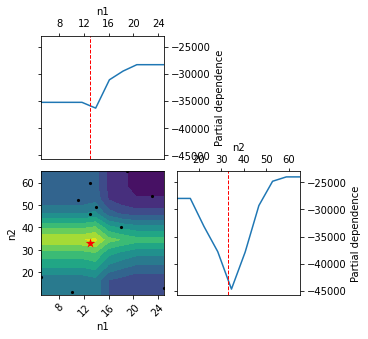

In [8]:
from skopt.plots import plot_objective
_ = plot_objective(results, n_points=10)

In [9]:
stats

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                     93.9479
Equity Final [$]                      64829.9
Equity Peak [$]                       64882.7
Return [%]                            548.299
Buy & Hold Return [%]                 703.458
Max. Drawdown [%]                    -34.2396
Avg. Drawdown [%]                    -5.89932
Max. Drawdown Duration      574 days 00:00:00
Avg. Drawdown Duration       50 days 00:00:00
# Trades                                   61
Win Rate [%]                           47.541
Best Trade [%]                        50.9727
Worst Trade [%]                      -15.9639
Avg. Trade [%]                        2.88777
Max. Trade Duration         183 days 00:00:00
Avg. Trade Duration          48 days 00:00:00
Profit Factor                         2.34198
Expectancy [%]                        9.00576
SQN                               

We can look into `stats['_strategy']` to access the Strategy _instance_ and its optimal parameter values.

In [10]:
stats._strategy

<Strategy SmaCross(n1=13,n2=33)>

In [11]:
bt.plot(plot_volume=False, plot_pl=False)

Strategy optimization managed to up its initial performance _on in-sample data_ by almost 50% and even beat simple
[buy & hold](https://en.wikipedia.org/wiki/Buy_and_hold).
In real life optimization, however, do **take steps to avoid
[overfitting](https://en.wikipedia.org/wiki/Overfitting)**.

## Trade data

In addition to backtest statistics returned by
[`Backtest.run()`](https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.run)
shown above, you can look into _individual trade returns_ and the changing _equity curve_ and _drawdown_ by inspecting the last few, internal keys in the result series.

In [12]:
stats.tail()

Sortino Ratio                                              0.70898
Calmar Ratio                                               0.08434
_strategy                                    SmaCross(n1=13,n2=33)
_equity_curve                     Equity  DrawdownPct DrawdownD...
_trades              Size  EntryBar  ExitBar  EntryPrice  ExitP...
dtype: object

The columns should be self-explanatory.

In [13]:
stats['_equity_curve']  # Contains equity/drawdown curves. DrawdownDuration is only defined at ends of DD periods.

,Equity,DrawdownPct,DrawdownDuration
2004-08-19,10000.00000,0.000000,NaT
2004-08-20,10000.00000,0.000000,NaT
2004-08-23,10000.00000,0.000000,NaT
2004-08-24,10000.00000,0.000000,NaT
2004-08-25,10000.00000,0.000000,NaT
...,...,...,...
2013-02-25,63596.25482,0.019827,NaT
2013-02-26,63545.05482,0.020616,NaT
2013-02-27,64317.05482,0.008717,NaT
2013-02-28,64430.65482,0.006966,NaT


In [14]:
stats['_trades']  # Contains individual trade data

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-55,74,86,179.59010,186.31,-369.59450,-0.037418,2004-12-03,2004-12-21,18 days
1,51,86,119,186.68262,196.96,524.14638,0.055053,2004-12-21,2005-02-08,49 days
2,-51,119,122,196.56608,186.66,505.21008,0.050396,2005-02-08,2005-02-11,3 days
3,56,122,131,187.03332,189.15,118.53408,0.011317,2005-02-11,2005-02-25,14 days
4,-57,131,162,188.77170,193.00,-241.01310,-0.022399,2005-02-25,2005-04-12,46 days
...,...,...,...,...,...,...,...,...,...,...
56,-79,1871,1892,585.14736,607.00,-1726.35856,-0.037346,2012-01-24,2012-02-23,30 days
57,73,1892,1932,608.21400,604.25,-289.37200,-0.006517,2012-02-23,2012-04-20,57 days
58,-73,1932,1989,603.04150,567.12,2622.26950,0.059567,2012-04-20,2012-07-12,83 days
59,82,1989,2062,568.25424,686.80,9720.75232,0.208614,2012-07-12,2012-10-24,104 days


Learn more by exploring further
[examples](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#tutorials)
or find more framework options in the
[full API reference](https://kernc.github.io/backtesting.py/doc/backtesting/index.html#header-submodules).